<a href="https://colab.research.google.com/github/Kat-ies/Coursework/blob/part-2/ML_methods_face_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Часть 1**
***Решение задачи классификации с использованием методов машинного обучения.***

In [6]:
import random
import numpy as np
from collections import namedtuple
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import namedtuple
from google.colab import drive
from sklearn.externals import joblib 
from PIL import Image, ImageDraw

# подключение гугл-диска
drive.mount('/content/drive')

PATH = '/content/drive/My Drive/Курсач/files/'
RANDOM_SEED = 42

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
#Загрузим всё необходимое
import matplotlib.pyplot as plt
import time
from collections import namedtuple
from sklearn.metrics import accuracy_score
import sklearn.model_selection as sk
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

Faces = namedtuple('Faces', 'img is_face filename rect')
Rectangle = namedtuple('Rectangle', 'x y w h')

all_features = joblib.load(os.path.join(PATH,'all_features.pkl'))
x_test = joblib.load(os.path.join(PATH,'x_test.pkl'))
y_train = joblib.load(os.path.join(PATH,'y_train.pkl'))
y_test = joblib.load(os.path.join(PATH,'y_test.pkl'))
time_df = joblib.load(os.path.join(PATH, 'Dataframes','time_df_part0.pkl'))

features_list = ['Haars features', 'Matrix features','Matrix + PCA features']
col_list = ['logreg_', 'tree_', 'knn_', 'svm_', 'randforest_', 'ada_boost_', 'grad_boost_']
categories = ['hf_train', 'mf_train','pca_train', 'hf_test', 'mf_test', 'pca_test']

print(len(all_features[0]))

70817


#Обучаем алгоритм и пробуем его применить

Теперь у нас есть всё, что необходимо для наших экспериментов. А значит мы можем заняться обучением и проверить, насколько хорошо наш алгоритм обучился:)   
Для обучения будем использовать следующие классические методы:


1.   Логистическая регрессия
2.   Решающее дерево
3.   Метод ближайших соседей
4.   Метод опорных векторов

А также для сравнения возьмём ансамбли:

1.   AdaBoost
2.   Случайный лес
3.   Градиентный бустинг.

Вдобавок ко всему вышеперечисленному я предлагаю засечь время (в сек), затраченное в среднем на обучение и предсказание каждым методом, чтобы определить для нашей задачи следующие вещи: 


*   Самый быстрый метод
*   Самый точный метод
*   "Лучший метод за свои деньги" (оптимальное соотношение точность - время работы)

В принципе при желании ещё можно провести анализ занимаемой памяти обученной модели.






#Примечание
Поскольку мы обучаем сразу несколько разных моделей на больших объёмах данных, будем сохранять наши обученные модели и их результаты предсказаний на всякий случай.

In [8]:
def training(x_train, y_train, feature_type, time_df, index):
    C = 1.0

    # берём классификаторы
    from sklearn import svm

    classifiers = [LogisticRegression(random_state = RANDOM_SEED),
                     DecisionTreeClassifier(random_state = RANDOM_SEED),
                     KNeighborsClassifier(n_neighbors = 300),
                     svm.LinearSVC(C=C, max_iter = 10000),
                     RandomForestClassifier(random_state = RANDOM_SEED),
                     AdaBoostClassifier(n_estimators = 100, random_state = RANDOM_SEED),
                     GradientBoostingClassifier(n_estimators = 100, random_state = RANDOM_SEED)]

    # обучим классификаторы и сохраним обученные модели
    for i,clf in enumerate(classifiers):
        t0 = time.time()
        clf.fit(x_train, y_train)
        t = time.time()
        time_df.loc[categories[index]][col_list[i]] += (t - t0)/len(x_train)
        joblib.dump(clf, os.path.join(PATH, 'Classificators', col_list[i] + feature_type + '.pkl')) 

In [9]:
def prediction(x_test, feature_type, df, time_df, index):
    #загружаем модели
    classifiers = []
    for i, clf_names in enumerate(col_list):
        classifiers.append(joblib.load(os.path.join(PATH, 'Classificators', col_list[i] + feature_type + '.pkl')))

    # проверяем способность прогнозирования после обучения
    for i, clf in enumerate(classifiers):
        t0 = time.time()
        df[col_list[i]] = clf.predict(x_test)
        t = time.time()
        time_df.loc[categories[index]][col_list[i]] += (t - t0)/len(x_test)


In [11]:
# подготовим данные для финального анализа
haars_df = pd.DataFrame(columns=col_list)
matrix_df = pd.DataFrame(columns=col_list)
matrix_pca_df = pd.DataFrame(columns=col_list)

training(all_features[0], y_train, 'hf', time_df, 0)
prediction(all_features[3], 'hf', haars_df, time_df, 3)
haars_df.insert(0, 'y_test', y_test)

training(all_features[1], y_train, 'mf', time_df, 1)
prediction(all_features[4], 'mf', matrix_df, time_df, 4)
matrix_df.insert(0, 'y_test', y_test)

training(all_features[2], y_train, 'mf_pca', time_df, 2)
prediction(all_features[5], 'mf_pca', matrix_pca_df, time_df, 5)
matrix_pca_df.insert(0, 'y_test', y_test)

#добавим ещё колонки
haars_df['all(1-5)'] = round(haars_df[haars_df.columns[1:len(col_list) + 1]].mean(axis=1))
matrix_df['all(1-5)'] = round(matrix_df[matrix_df.columns[1:len(col_list) + 1]].mean(axis=1))
matrix_pca_df['all(1-5)'] = round(matrix_pca_df[matrix_df.columns[1:len(col_list) + 1]].mean(axis=1))


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sci

In [12]:
#coxpaним датафреймы, чтобы в следующий раз можно было обойтись без обучения
haars_df.to_csv(os.path.join(PATH,'Dataframes','haars_df.csv'))
matrix_df.to_csv(os.path.join(PATH,'Dataframes','matrix_df.csv'))
matrix_pca_df.to_csv(os.path.join(PATH,'Dataframes','matrix_pca_df.csv'))
time_df.to_csv(os.path.join(PATH,'Dataframes','time_df_part1.csv'))

In [13]:
haars_df[:5]

,y_test,logreg_,tree_,knn_,svm_,randforest_,ada_boost_,grad_boost_,all(1-5)
0,0,0,0,0,0,0,0,0,0.0
1,1,1,0,0,1,0,0,1,0.0
2,1,1,1,1,1,1,1,1,1.0
3,0,1,0,0,1,0,0,0,0.0
4,1,1,1,1,1,1,1,1,1.0


In [14]:
matrix_df[:5]

,y_test,logreg_,tree_,knn_,svm_,randforest_,ada_boost_,grad_boost_,all(1-5)
0,0,0,0,0,0,0,0,0,0.0
1,1,1,1,1,1,1,1,1,1.0
2,1,1,0,0,1,1,0,1,1.0
3,0,0,0,0,0,0,0,0,0.0
4,1,1,1,1,1,1,1,1,1.0


In [15]:
matrix_pca_df[:5]

,y_test,logreg_,tree_,knn_,svm_,randforest_,ada_boost_,grad_boost_,all(1-5)
0,0,0,0,0,1,0,0,0,0.0
1,1,1,1,1,1,1,0,1,1.0
2,1,1,1,0,0,1,1,1,1.0
3,0,0,0,0,1,0,1,0,0.0
4,1,1,1,1,1,1,1,1,1.0


# Результаты
Давайте немного проанализируем, что же у нас получилось.

In [18]:
from sklearn.metrics import accuracy_score
from pandas import read_csv

col_list.append('all(1-5)')

haars_df = read_csv(os.path.join(PATH,'Dataframes','haars_df.csv'), index_col=0)
matrix_df = read_csv(os.path.join(PATH,'Dataframes','matrix_df.csv'), index_col=0)
matrix_pca_df = read_csv(os.path.join(PATH,'Dataframes','matrix_pca_df.csv'), index_col=0)
time_df = read_csv(os.path.join(PATH,'Dataframes','time_df_part1.csv'), index_col=0)
accuracy_df = pd.DataFrame(features_list, index=['1', '2', '3'], columns=['features'])

for i, cols in enumerate(col_list):
    accuracy_df[cols] = [accuracy_score(haars_df['y_test'], haars_df[cols]),accuracy_score(matrix_df['y_test'], matrix_df[cols]),
                         accuracy_score(matrix_pca_df['y_test'], matrix_pca_df[cols])]

accuracy_df[:]

,features,logreg_,tree_,knn_,svm_,randforest_,ada_boost_,grad_boost_,all(1-5)
1,Haars features,0.730408,0.726510,0.781327,0.731636,0.819961,0.800856,0.808566,0.807252
2,Matrix features,0.757011,0.704906,0.768618,0.753961,0.824155,0.755401,0.795942,0.808227
3,Matrix + PCA features,0.753961,0.693341,0.771668,0.555028,0.816869,0.768449,0.792383,0.807845


In [19]:
time_df[:]

,logreg_,tree_,knn_,svm_,randforest_,ada_boost_,grad_boost_
hf_train,0.001695,0.001835,0.001680,0.009068,0.002654,0.002629,0.004308
mf_train,0.000123,0.000893,0.000138,0.023109,0.002143,0.004662,0.013027
pca_train,0.000053,0.000278,0.000037,0.008199,0.001519,0.002028,0.005316
hf_test,0.001639,0.001639,0.030248,0.001638,0.001665,0.001674,0.001641
mf_test,0.000017,0.000016,0.108185,0.000018,0.000062,0.000164,0.000021
pca_test,0.000016,0.000015,0.014342,0.000015,0.000043,0.000051,0.000017


# Анализ ошибочных детекций
Попробуем организовать вывод изображений, на которых ошибается каждый из алгоритмов по отдельности. А также посмотрим, на чём ошибается наш "коллективный разум".

Также не будем забывать о том, что признаки Хоара плохо работают для детекции лиц, расположенных под углом. Максимальный угол отклонения мб 30°.

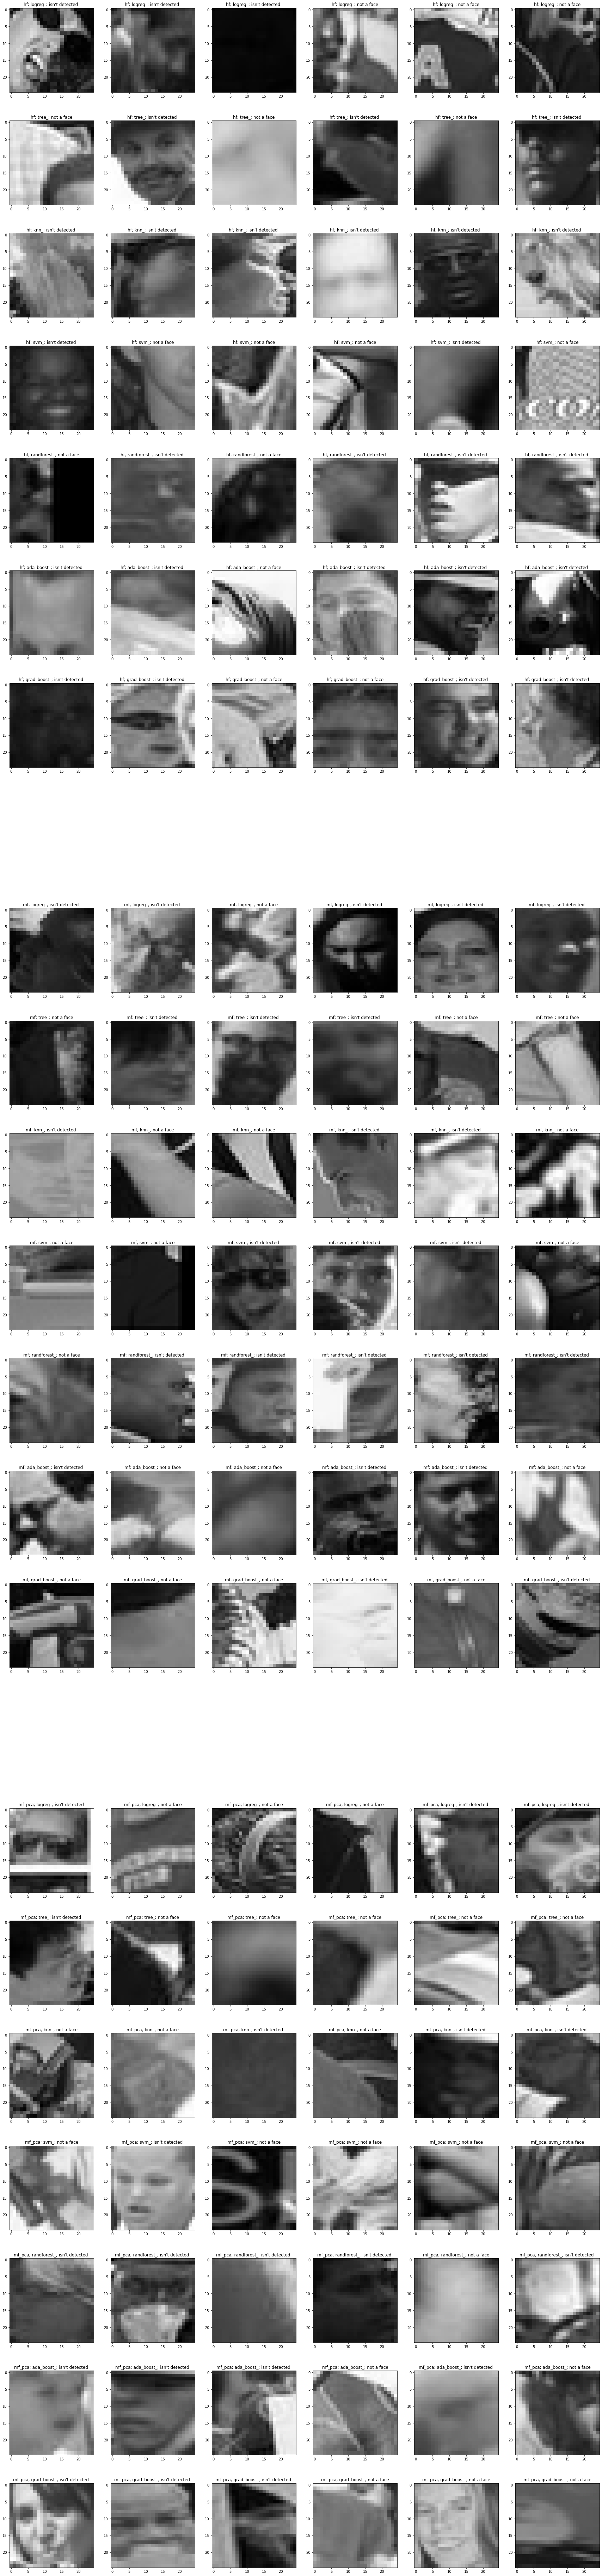

In [26]:
fig = plt.figure(figsize=(30, 140))
COLUMNS = 6
ROWS = 24

# ax enables access to manipulate each of subplots
ax = []
np.random.seed(RANDOM_SEED)
indexes = np.arange(1,144 ,48)

def plotting(dataframe, feature_type, index):

    for i in range(len(col_list)):
        for j in range(COLUMNS):
            rand_num = np.random.randint(0, len(dataframe))

            while dataframe.iloc[rand_num][col_list[i]] == dataframe.iloc[rand_num]['y_test']:
                rand_num = np.random.randint(0, len(dataframe))

            image = x_test[rand_num].img
            ax.append(fig.add_subplot(ROWS, COLUMNS, index))
            index += 1

            if dataframe.iloc[rand_num]['y_test'] == 0:
                ax[-1].set_title(feature_type + '; ' + col_list[i] + '; not a face')
            else:
                ax[-1].set_title(feature_type + '; ' + col_list[i] + '; isn\'t detected ')
    
            plt.imshow(image, cmap='gray', vmin=0, vmax=255)
        
plotting(haars_df,'hf',indexes[0])
plotting(matrix_df,'mf',indexes[1])
plotting(matrix_pca_df,'mf_pca',indexes[2])


plt.show()  # finally, render the plot